In [4]:
KD_path = "ThuanHoa/KhoanhDat/ThuanHoa_TKDD2022.shp"
KetQuaPhanLoaiDat = "KetQuaPhanLoaiDat.tif"

In [5]:
import geopandas as gpd
import rasterio
import os
import rioxarray
import numpy as np
import xarray as xr

In [6]:
## map code
CODE_MAP = {
    "BHK": 2,
    "CLN": 3,
    "DGD": 6,
    "DGT": 6,
    "DNL": 6,
    "DRA": 6,
    "DSH": 6,
    "DTL": 5,
    "DTS": 6,
    "DYT": 6,
    "LUC": 1,
    "NKH": 3,
    "NTD": 6,
    "NTS": 4,
    "ONT": 6,
    "SKC": 6,
    "SKX": 6,
    "SON": 5,
    "TMD": 6,
    "TON": 6,
    "TSC": 6,
}

HT_MAP = {
    "NN": {
        "name": "Đất Nông Nghiệp",
        "data": [1, 2, 3, 4]
    },
    "PNN": {
        "name": "Đất Phi Nông Nghiệp",
        "data": [6]
    },
    "TQ": {
        "name": "Đất Thổ Quả",
        "data": [15]
    }
}

In [7]:
gdf = gpd.read_file(KD_path, crs="EPSG:9209")
polygon = gdf.geometry.values
label = gdf.tenchu.values
squares =  gdf.dientich.values

In [8]:
squares

array([5058.2,  407.6, 4537.2, ...,  470.9,  341.9, 2307.4])

In [9]:
label

array(['SKC', 'ONT', 'ONT(1782.60);CLN(2754.70)', ..., 'ONT',
       'ONT(297.10);CLN(44.80)', 'ONT(1485.50);CLN(821.90)'], dtype=object)

<Axes: >

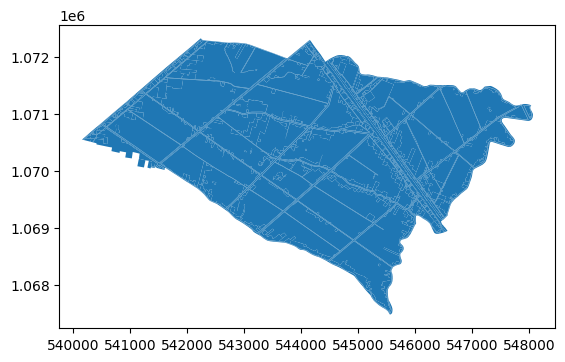

In [10]:
gdf.plot()

In [61]:
print(gdf.geometry[0])

POLYGON ((540179.7 1070550.084, 540209.964 1070575.703, 540210.764 1070577.703, 540212.264 1070577.653, 540297.974 1070574.813, 540315.563 1070574.23, 540301.202 1070519.021, 540179.7 1070550.084))


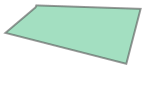

In [52]:
gdf.geometry.iloc[0]

In [11]:
ouput_image = rioxarray.open_rasterio(KetQuaPhanLoaiDat)

<xarray.DataArray (band: 1, y: 532, x: 830)>
[441560 values with dtype=float64]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 5.95e+05 5.95e+05 5.95e+05 ... 6.033e+05 6.033e+05
  * y            (y) float64 1.072e+06 1.072e+06 ... 1.067e+06 1.067e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

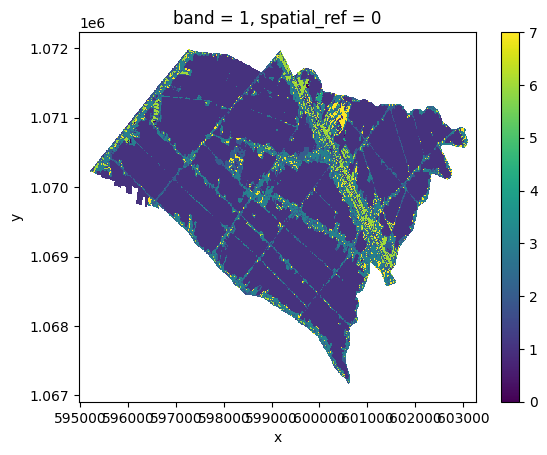

In [11]:
ouput_image.plot()
ouput_image

In [ ]:
temp = ouput_image.rio.clip([polygon[1]], "EPSG:9209")
temp = temp.where((temp != 3.0), np.nan)
temp

In [ ]:
for i in range(10):
    print(polygon[i])

In [13]:
lb = label[4]
code_lb = CODE_MAP.get(lb, 15)
print(code_lb)

1


In [29]:
def eliminate_noise(qr, og_square):
    test_sq = np.squeeze(qr)
    square =0
    for x in range(test_sq.shape[0]):
        for y in range(test_sq.shape[1]):
            if(not np.isnan(test_sq[x][y])):
                square += 100

    if(square/og_square > 0.75):
         return qr.where(False, np.nan)
    return qr


In [30]:
result = {}
sub_result= {}
for key, values in HT_MAP.items():
    print(f"process {key}")
    array_list = []
    deleted_array = []
    for i in range(len(polygon)):
        po = polygon[i]
        lb = label[i]
        code_lb = CODE_MAP.get(lb, 15)
        s = 0
        try:
            qr = ouput_image.rio.clip([po], "EPSG:9209")
            if code_lb in values["data"]:
                if code_lb == 6:
                    qr = qr.where((qr != 6.0), np.nan)
                    # qr = qr.where((qr != 3.0), np.nan)
                elif code_lb == 15:
                    qr = qr.where((qr != 6.0), np.nan)
                    qr = qr.where((qr != 3.0), np.nan)
                else: 
                    qr = qr.where(qr != float(code_lb), np.nan)
                 
                
                # print(qr)
            else:
                qr.values[:, :, :] = np.nan
            #calculate square and eliminte small pieces 
            new_qr = eliminate_noise(qr, 10000)
            
            
            array_list.append(qr)
            deleted_array.append(new_qr)
        except Exception as e:
           pass
    result.update({key: array_list})
    sub_result.update({key: deleted_array})

process NN
process PNN
process TQ


In [ ]:
result

In [ ]:
sub_result

In [102]:
test = xr.DataArray(np.random.rand(3,3), dims=['x', 'y'])
test = test *10
test = test.where(test>5, 0)
test

<xarray.DataArray (x: 3, y: 3)>
array([[5.10942001, 0.        , 5.63266924],
       [8.37634064, 7.34653038, 8.1392791 ],
       [7.25012133, 9.15675985, 0.        ]])
Dimensions without coordinates: x, y

In [33]:
from rioxarray.merge import merge_arrays
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
colors = [
    "#abcee9",
    "#ffffc0",
    "#c4ff9e",
    "#ffd6a8",
    "#93ddda",
    "#1aeef7",
    "#ffa7f2",
    "#33ee33"
]
labels = [
    "Lúa tôm",
    "Lúa",
    "CHN",
    "CLN",
    "TS",
    "Sông",
    "Đất xây dựng",
    "Rừng"
]
cmap = ListedColormap(colors)

/tmp/ipykernel_154/485899268.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(labels)


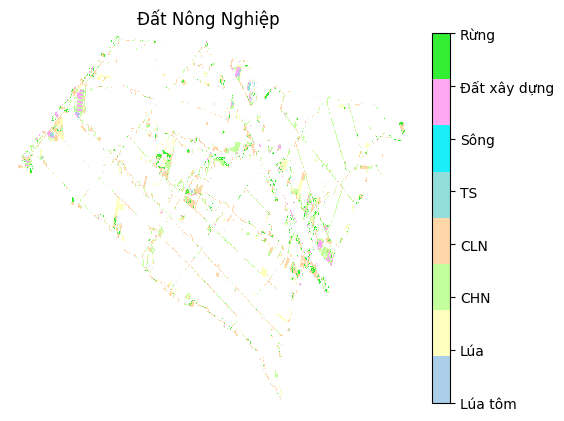

/tmp/ipykernel_154/485899268.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(labels)


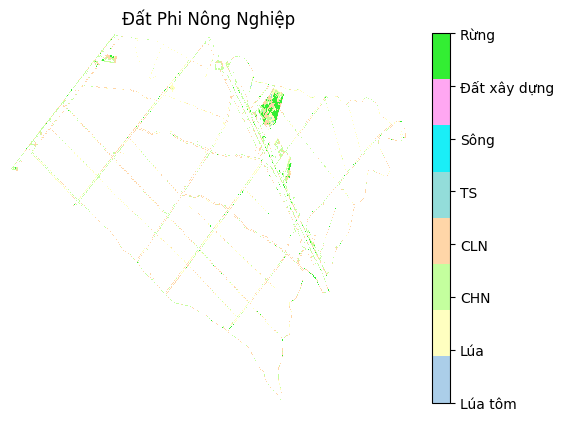

/tmp/ipykernel_154/485899268.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(labels)


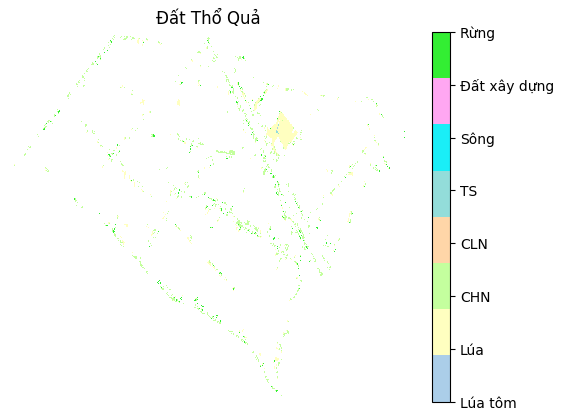

In [34]:
save_path = "ThuanHoa/KetQua"
if not os.path.exists(save_path):
    os.mkdir(save_path)

for k, v in result.items():
    rs = merge_arrays(v, nodata = np.nan)
    rs.rio.to_raster(f"{save_path}/{k}.tif")
    img = rs.plot(cmap=cmap, add_colorbar=False)
    cbar = plt.colorbar(img)
    cbar.ax.set_yticklabels(labels)
    plt.title(f'{HT_MAP[k]["name"]}')
    plt.axis('off')
    plt.show()   

/tmp/ipykernel_154/2515831464.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(labels)


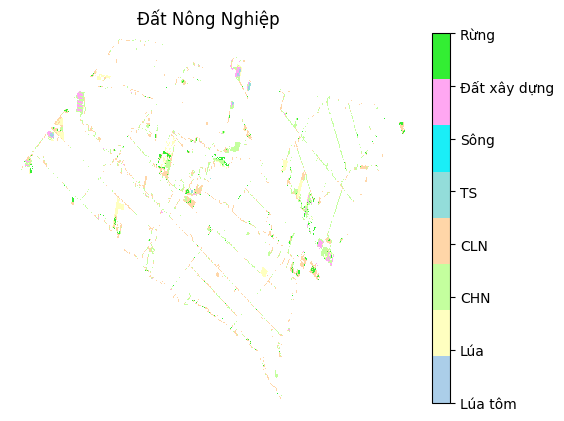

/tmp/ipykernel_154/2515831464.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(labels)


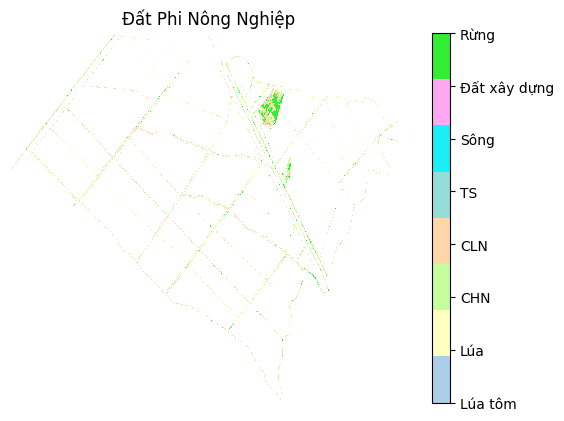

/tmp/ipykernel_154/2515831464.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(labels)


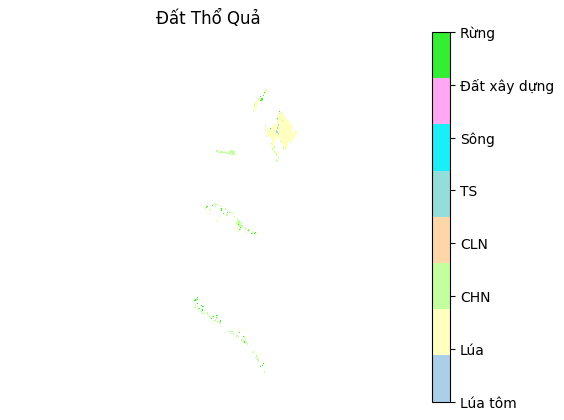

In [35]:
for k, v in sub_result.items():
    rs = merge_arrays(v, nodata = np.nan)
    rs.rio.to_raster(f"{save_path}/{k}-sub.tif")
    img = rs.plot(cmap=cmap, add_colorbar=False)
    cbar = plt.colorbar(img)
    cbar.ax.set_yticklabels(labels)
    plt.title(f'{HT_MAP[k]["name"]}')
    plt.axis('off')
    plt.show()

In [9]:
# Add the three datasets into a DataArray wth new dimension by name

import pandas as pd
xx = []

for k, v in result.items():
    rs = merge_arrays(v, nodata = np.nan)
    xx.append(rs.squeeze(drop=True))
xx = xr.concat(xx, pd.Index([HT_MAP[x]['name'] for x in HT_MAP], name='name'))

In [10]:
# Holoviews with "groupby" name dimension - adds a "name" dropdown widget to select between the three datasets

import hvplot.xarray
from holoviews import opts
from datashader import reductions
from bokeh.models.tickers import FixedTicker

colorval = list(range(len(colors)))
options = {
    'cmap': colors,
    'clim': (0, 8),
    'aspect': 'equal',
    'height': 400,
    'colorbar_opts': {
        'major_label_overrides': dict(zip(colorval, labels)),
        'major_label_text_align': 'left',
        'ticker': FixedTicker(ticks=colorval),
    },
}
                                      
xx.hvplot(
    groupby = 'name',
    rasterize = True,                        # Use Datashader, particularly useful for dask arrays
    aggregator = reductions.mode(),          # Datashader selects mode value, requires 'hv.Image'
).options(opts.Image(**options))

:DynamicMap   [name]
   :Image   [y,x]   (value)